In [1]:
import os
import glob
import duckdb
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, accuracy_score

In [2]:
import joblib  

# Modeli dosya yolundan yükleyelim
model_path = r"C:\Users\Abdulkadir\Desktop\TurkTelekom\capstone\optimized_lightgbm.pkl"
optimized_lgbm = joblib.load(model_path)

print("✅ Model başarıyla yüklendi!")

✅ Model başarıyla yüklendi!


In [3]:
# Test setini yükle
test_df = pd.read_csv("test_set.csv")

# Gerçek churn değerlerini sakla (karşılaştırma için)
true_churn = test_df["churn"].copy()  

# Modelin erişmemesi için churn sütununu kaldır
test_df = test_df.drop(columns=["churn"], errors="ignore")

### Eksik Veri analizi

In [4]:
# 1️⃣ roaming_usage → Eğer eksikse, hiç kullanmamıştır (0 ile doldur)
test_df['roaming_usage'] = test_df['roaming_usage'].fillna(0)

# 2️⃣ auto_payment → Eksikler -1 ile doldurulmalı ve int'e çevrilmeli
test_df['auto_payment'] = test_df['auto_payment'].fillna(-1).astype(int)

# 3️⃣ avg_call_duration → Eğer fatura bilgisi (monthly_charge) eksikse veya 0'sa, hiç konuşma yapmamıştır (0 ile doldur)
test_df.loc[
    ((test_df['avg_call_duration'].isnull()) | (test_df['avg_call_duration'] == 0)) &
    ((test_df['data_usage'].isnull()) | (test_df['data_usage'] == 0)) &
    (test_df['monthly_charge'].isnull()), 
    'monthly_charge'
] = 0

test_df['avg_call_duration'] = test_df['avg_call_duration'].fillna(-1)

# 4️⃣ call_drops → Eğer service_type "Broadband" ise 0 ile doldur, kalanları medyan ile doldur
test_df.loc[test_df['service_type'] == "Broadband", 'call_drops'] = 0
test_df['call_drops'] = test_df['call_drops'].fillna(test_df['call_drops'].median())

# 5️⃣ monthly_charge → Yaş (age) ve avg_top_up_count'e göre doldur (Sadece NaN olanları değiştir)
test_df['monthly_charge'] = test_df['monthly_charge'].where(test_df['monthly_charge'].notnull(),
    test_df.groupby(['age', 'avg_top_up_count'])['monthly_charge'].transform('mean'))

# 6️⃣ data_usage → Eksik kayıtları silebiliriz çünkü oran düşük
test_df = test_df.dropna(subset=['data_usage'])

# 7️⃣ tenure → Yaş bazlı gruplara göre dolduralım (Sadece NaN olanları değiştir)
test_df['tenure'] = test_df['tenure'].where(test_df['tenure'].notnull(),
    test_df.groupby('age')['tenure'].transform('median'))

# 8️⃣ Son eksik verileri kontrol edelim
print("Eksik değer sayıları:")
print(test_df.isnull().sum())

Eksik değer sayıları:
id                        0
age                       0
tenure                    0
service_type              0
avg_call_duration         0
data_usage                0
roaming_usage             0
monthly_charge            5
overdue_payments          0
auto_payment              0
avg_top_up_count          0
call_drops                0
customer_support_calls    0
satisfaction_score        0
apps                      0
dtype: int64


In [5]:
test_df = test_df.dropna(subset=['monthly_charge'])

#### Yeni Özellik

In [6]:
# Apps sütununu işlemeyi unutmayalım
test_df["apps"] = test_df["apps"].apply(lambda x: x if x != "[]" else "")
test_df["app_count"] = test_df["apps"].apply(lambda x: len(x.split(",")) if x else 0)

test_df["dissatisfaction_score"] = test_df["monthly_charge"] / (test_df["data_usage"] + test_df["avg_call_duration"] + 1)


# Memnuniyet Kategorisi
test_df["satisfaction_category"] = pd.cut(test_df["satisfaction_score"], bins=[0, 4, 7, 10], labels=["Düşük", "Orta", "Yüksek"])

# Destek Çağrılarının Etkisi
test_df["support_call_impact"] = test_df["customer_support_calls"] / (test_df["satisfaction_score"] + 1)

# Aylık Fatura Kategorisi
test_df["billing_category"] = pd.cut(test_df["monthly_charge"], bins=[0, 250, 500, 1000, 2500], labels=["Düşük", "Orta", "Yüksek", "Premium"])

# Finansal Risk Skoru
test_df["financial_risk_score"] = test_df["monthly_charge"] * test_df["overdue_payments"] / (test_df["avg_top_up_count"] + 1)

# Yaş Segmenti
test_df["age_group"] = pd.cut(test_df["age"], bins=[16, 25, 35, 50, 85], labels=["Genç", "Orta", "Yetişkin", "Yaşlı"])

# Roaming Kullanım Segmenti
test_df["roaming_usage_category"] = pd.cut(test_df["roaming_usage"], bins=[-1, 0, 10, 50, 1000], labels=["Hiç Kullanmadı", "Ara Sıra", "Sık Kullanıcı", "Çok Sık Kullanıcı"])

# Sadakat Skoru
test_df["loyalty_score"] = test_df["tenure"] * test_df["avg_top_up_count"] / (test_df["customer_support_calls"] + 1)

# Fatura Ağırlığı
test_df["billing_weight"] = test_df["monthly_charge"] / (test_df["age"] + 1)


In [7]:
test_df.to_csv("HadiArtık.csv" , index =  False)

### Encoding

In [8]:
# Mapping tanımları
service_type_map = {"Prepaid": 0, "Broadband": 1, "Postpaid": 2}
billing_category_map = {"Düşük": 0, "Orta": 1, "Yüksek": 2, "Premium": 3}
age_group_map = {"Yaşlı": 0, "Orta": 1, "Yetişkin": 2, "Genç": 3}
roaming_usage_map = {"Hiç Kullanmadı": 0, "Ara Sıra": 1, "Sık Kullanıcı": 2, "Çok Sık Kullanıcı": 3}

# Encoding
test_df["service_type"] = test_df["service_type"].map(service_type_map)
test_df["billing_category"] = test_df["billing_category"].map(billing_category_map)
test_df["age_group"] = test_df["age_group"].map(age_group_map)
test_df["roaming_usage_category"] = test_df["roaming_usage_category"].map(roaming_usage_map)

# Label Encoding - Satisfaction Category
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
test_df["satisfaction_category"] = le.fit_transform(test_df["satisfaction_category"])


In [9]:
test_df = test_df.drop(columns=["id", "apps"])

In [10]:
category_cols = ["billing_category", "roaming_usage_category", "age_group"]
for col in category_cols:
    test_df[col] = test_df[col].astype(int)

print("✅ Test verisi başarıyla hazırlandı!")


✅ Test verisi başarıyla hazırlandı!


In [11]:
# # Modelin beklediği feature'ları al
# expected_features = optimized_lgbm.feature_name_

# # Test setindeki feature'ları al
# actual_features = X_real_test.columns.tolist()

# # Eksik olanları bul
# missing_features = list(set(expected_features) - set(actual_features))

# print("⚠️ Eksik olan feature:", missing_features)


In [12]:
# Modelin beklediği formatta X_test'i oluştur
X_real_test = test_df.copy()

# Model ile tahmin yap
y_real_pred = optimized_lgbm.predict(X_real_test)
y_real_proba = optimized_lgbm.predict_proba(X_real_test)[:, 1]

# Sonuçları test setine ekleyelim
test_df["churn_prediction"] = y_real_pred
test_df["churn_probability"] = y_real_proba

print("✅ Tahmin başarıyla yapıldı!")
print(test_df[["churn_prediction", "churn_probability"]].head(10))


✅ Tahmin başarıyla yapıldı!
   churn_prediction  churn_probability
0             False              0.127
1              True              0.626
2             False              0.439
3             False              0.296
4              True              0.632
5              True              0.644
6              True              0.764
7             False              0.096
8             False              0.092
9              True              0.620


In [13]:
print("Test set boyutu:", test_df.shape[0])
print("Gerçek churn etiketleri boyutu:", true_churn.shape[0])

Test set boyutu: 950117
Gerçek churn etiketleri boyutu: 1000000


In [14]:
# Güncellenmiş true_churn dizisini oluştur
true_churn = true_churn.loc[test_df.index].reset_index(drop=True)

print("✅ Güncellenmiş churn etiketi boyutu:", true_churn.shape[0])


✅ Güncellenmiş churn etiketi boyutu: 950117


In [15]:
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

# Model performans raporu
print("\n🔍 Final Model Evaluation:")
print(classification_report(true_churn, test_df["churn_prediction"]))

print("\n📈 Final ROC AUC Score:", roc_auc_score(true_churn, test_df["churn_probability"]))
print("⚡ Final Accuracy Score:", accuracy_score(true_churn, test_df["churn_prediction"]))



🔍 Final Model Evaluation:
              precision    recall  f1-score   support

       False       1.00      0.67      0.80    937430
        True       0.03      0.82      0.06     12687

    accuracy                           0.67    950117
   macro avg       0.51      0.74      0.43    950117
weighted avg       0.98      0.67      0.79    950117


📈 Final ROC AUC Score: 0.7980563468420538
⚡ Final Accuracy Score: 0.6679335281865286


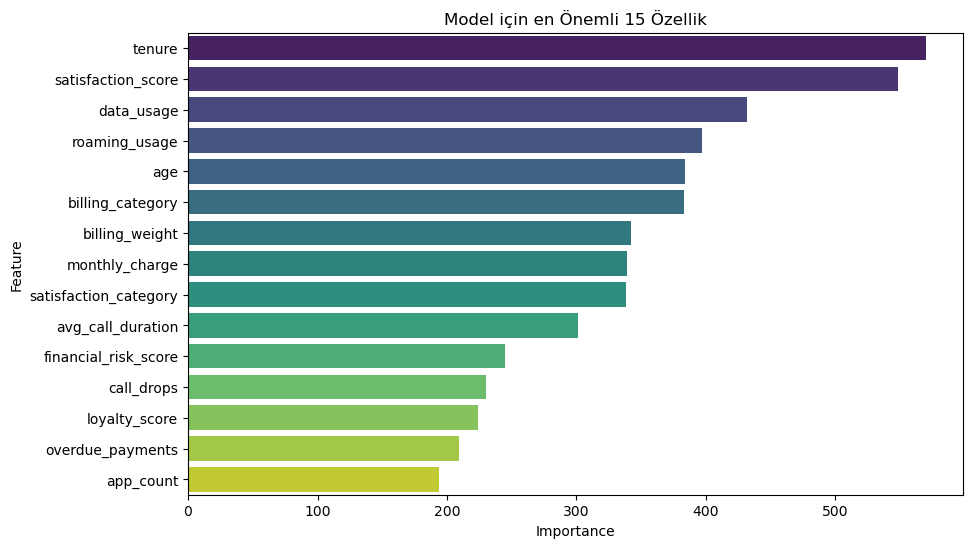

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Feature importance'ı alalım
feature_importances = optimized_lgbm.feature_importances_
feature_names = X_real_test.columns

# DataFrame'e çevirelim
feat_imp_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importances})
feat_imp_df = feat_imp_df.sort_values(by="Importance", ascending=False)

# Görselleştirelim
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feat_imp_df.head(15), palette="viridis")
plt.title("Model için en Önemli 15 Özellik")
plt.show()


In [17]:
# Churn olasılıklarını büyükten küçüğe sıralayalım
top_risky_customers = test_df.sort_values(by="churn_probability", ascending=False).head(500)

# En riskli 10 müşteriyi görüntüleyelim
top_risky_customers[["churn_probability", "tenure", "satisfaction_score","data_usage", "age","billing_category" , "billing_weight" , "monthly_charge", "roaming_usage","financial_risk_score"]].head(10)




,churn_probability,tenure,satisfaction_score,data_usage,age,billing_category,billing_weight,monthly_charge,roaming_usage,financial_risk_score
959084,0.914,59.000,2.060,5.720,50,0,1.805,92.030,21.780,368.120
442420,0.914,26.000,1.030,3.670,55,1,7.718,432.220,48.330,1296.660
979832,0.911,6.000,2.490,2.880,33,1,10.565,359.210,53.770,1436.840
945610,0.906,3.000,1.390,13.850,33,2,23.399,795.550,20.050,3182.200
84942,0.905,13.000,2.090,169.970,34,1,9.911,346.880,20.980,1387.520
718346,0.904,70.000,2.530,7.760,34,1,10.722,375.270,53.310,1501.080
486461,0.904,10.000,2.750,199.540,35,2,24.580,884.870,4.930,2654.610
253456,0.903,136.000,2.870,14.400,49,2,17.416,870.810,56.850,3483.240
119935,0.902,53.000,1.170,8.460,45,1,7.333,337.340,51.620,1012.020
177528,0.902,4.000,2.690,166.360,39,2,15.471,618.820,46.020,2475.280
